In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
df_RPI_CPI = pd.read_csv('../raw_data/RPI_CPI.csv')

In [5]:
df_RPI_CPI.set_index('Date', inplace=True)
df_RPI_CPI.index = pd.to_datetime(df_RPI_CPI.index)

In [6]:
df_RPI_CPI.tail(12)

,RPI,CPI
Date,,
2021-08-01,307.4,112.1
2021-09-01,308.6,112.4
2021-10-01,312.0,113.6
2021-11-01,314.3,114.5
2021-12-01,317.7,115.1
2022-01-01,317.7,114.9
2022-02-01,320.2,115.8
2022-03-01,323.5,117.1
2022-04-01,334.6,120.0


In [7]:
df_RPI = df_RPI_CPI.drop('CPI', axis=1)

In [8]:
df_RPI

,RPI
Date,
1987-01-01,100.0
1987-02-01,100.4
1987-03-01,100.6
1987-04-01,101.8
1987-05-01,101.9
...,...
2022-03-01,323.5
2022-04-01,334.6
2022-05-01,337.1


In [9]:
df_RPI.index = pd.to_datetime(df_RPI.index)

In [10]:
type(df_RPI.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [11]:
from darts import TimeSeries
from sklearn.model_selection import train_test_split

In [12]:
df_RPI['Date'] = df_RPI.index

In [13]:
df_RPI.index = pd.RangeIndex(start=0, stop=len(df_RPI))

In [14]:
df_RPI

,RPI,Date
0,100.0,1987-01-01
1,100.4,1987-02-01
2,100.6,1987-03-01
3,101.8,1987-04-01
4,101.9,1987-05-01
...,...,...
422,323.5,2022-03-01
423,334.6,2022-04-01
424,337.1,2022-05-01
425,340.0,2022-06-01


In [15]:
df_RPI_88_93 = df_RPI[12:72]
df_RPI_93_94 = df_RPI[72:84]

In [16]:
ts_RPI_88_93 = TimeSeries.from_dataframe(df_RPI_88_93, 
        value_cols=["RPI"], 
        time_col="Date")

ts_RPI_93_94 = TimeSeries.from_dataframe(df_RPI_93_94, 
        value_cols=["RPI"], 
        time_col="Date")

In [17]:
from darts.models.forecasting.auto_arima import AutoARIMA

model = AutoARIMA(start_p=1, max_p=6,
                       start_q=1, max_q=6,
                       start_P=1, max_P=6,
                       start_Q=1, max_Q=6,
                       m=12,
                       trend='t',
                       seasonal=True,
                       trace=True)
model.fit(ts_RPI_88_93)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=143.949, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=104.634, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=124.862, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=143.949, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=134.049, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=122.131, Time=0.06 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=92.979, Time=0.64 sec
 ARIMA(1,1,0)(3,0,1)[12] intercept   : AIC=88.689, Time=1.57 sec
 ARIMA(1,1,0)(3,0,0)[12] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(1,1,0)(4,0,1)[12] intercept   : AIC=91.670, Time=2.68 sec
 ARIMA(1,1,0)(3,0,2)[12] intercept   : AIC=90.548, Time=1.46 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=92.815, Ti

In [18]:
from darts.models.forecasting.arima import ARIMA
model_ARIMA = ARIMA(p=1,
                    q=1,
                    d=1,
                    seasonal_order=(3,0,0,12),
                    trend='t',
                    random_state=0)

In [19]:
model_ARIMA.fit(ts_RPI_88_93)

In [20]:
pred_93_94 = model_ARIMA.predict(12)

In [21]:
df_pred_93_94 = pred_93_94.pd_dataframe()

In [22]:
df_pred_93_94['Date'] = df_pred_93_94.index

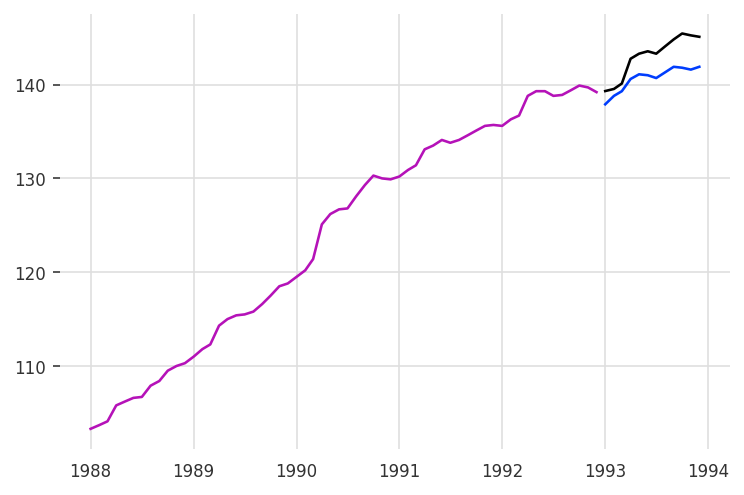

In [23]:
fig1 = plt.plot(df_pred_93_94['Date'],df_pred_93_94['RPI'])
fig2 = plt.plot(df_RPI_93_94['Date'],df_RPI_93_94['RPI'])
fig3 = plt.plot(df_RPI_88_93['Date'],df_RPI_88_93['RPI'])
plt.show()

In [24]:
dataframes = {}
for i in range(29):
    year = 88 + i
    dataframes[f'df_RPI_{year}_{year+5}'] = df_RPI[(year-87)*12:(year-87)*12+60]
    dataframes[f'df_RPI_{year+5}_{year+6}'] = df_RPI[(year-87)*12+60:(year-87)*12+72]
    
# dataframes['df_RPI_88_93']
    
# for k,v in dataframes:
#     k = v
    
# df_RPI_88_93
# (edited)

In [25]:
dataframes = {}
darts_ts ={}
for i in range(29):
    year = 88 + i
    dataframes[f'df_RPI_{year}_{year+5}'] = df_RPI[(year-87)*12:(year-87)*12+60]
    dataframes[f'df_RPI_{year+5}_{year+6}'] = df_RPI[(year-87)*12+60:(year-87)*12+72]
    
    darts_ts[f'ts_RPI_{year}_{year+5}'] = TimeSeries.from_dataframe(df_RPI[(year-87)*12:(year-87)*12+60], 
        value_cols=["RPI"], 
        time_col="Date")
    darts_ts[f'ts_RPI_{year+5}_{year+6}'] = TimeSeries.from_dataframe(df_RPI[(year-87)*12+60:(year-87)*12+72],
                                                                              value_cols=["RPI"], 
                                                                              time_col="Date")
                                     
# dataframes['df_RPI_88_93']
    
# for k,v in dataframes:
#     k = v
    
# df_RPI_88_93
# (edited)

In [26]:
darts_ts['ts_RPI_121_122']

<TimeSeries (DataArray) (Date: 12, component: 1, sample: 1)>
array([[[294.6]],

       [[296. ]],

       [[296.9]],

       [[301.1]],

       [[301.9]],

       [[304. ]],

       [[305.5]],

       [[307.4]],

       [[308.6]],

       [[312. ]],

       [[314.3]],

       [[317.7]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2021-01-01 2021-02-01 ... 2021-12-01
  * component  (component) object 'RPI'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [27]:
ts_RPI_88_93 = TimeSeries.from_dataframe(df_RPI_88_93, 
        value_cols=["RPI"], 
        time_col="Date")

ts_RPI_93_94 = TimeSeries.from_dataframe(df_RPI_93_94, 
        value_cols=["RPI"], 
        time_col="Date")

In [28]:
dataframes['df_RPI_121_122']

,RPI,Date
408,294.6,2021-01-01
409,296.0,2021-02-01
410,296.9,2021-03-01
411,301.1,2021-04-01
412,301.9,2021-05-01
413,304.0,2021-06-01
414,305.5,2021-07-01
415,307.4,2021-08-01
416,308.6,2021-09-01
417,312.0,2021-10-01


In [29]:
dataframes['df_RPI_116_121']

,RPI,Date
348,258.8,2016-01-01
349,260.0,2016-02-01
350,261.1,2016-03-01
351,261.4,2016-04-01
352,262.1,2016-05-01
353,263.1,2016-06-01
354,263.4,2016-07-01
355,264.4,2016-08-01
356,264.9,2016-09-01
357,264.8,2016-10-01


In [30]:
model = AutoARIMA(start_p=1, max_p=6,
                       start_q=1, max_q=6,
                       start_P=1, max_P=6,
                       start_Q=1, max_Q=6,
                       m=12,
                       trend='t',
                       seasonal=True,
                       trace=True)
model.fit(darts_ts['ts_RPI_116_121'])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=169.276, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=190.581, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=166.381, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=172.131, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=190.581, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=188.537, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=167.995, Time=0.38 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=166.931, Time=0.19 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=171.536, Time=0.08 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=166.768, Time=0.06 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=168.055, Time=0.16 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=168.239, Time=0.15 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=166.840, Time=0.11 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   

In [31]:
model_ARIMA = ARIMA(p=1,
                    d=1,
                    q=0,
                    seasonal_order=(1,0,0,12),
                    trend='t',
                    random_state=0)

In [32]:
model_ARIMA.fit(darts_ts['ts_RPI_116_121'])

In [33]:
pred_121_122 = model_ARIMA.predict(12)

In [34]:
df_pred_121_122 = pred_121_122.pd_dataframe()

In [35]:
df_pred_121_122['Date'] = df_pred_121_122.index

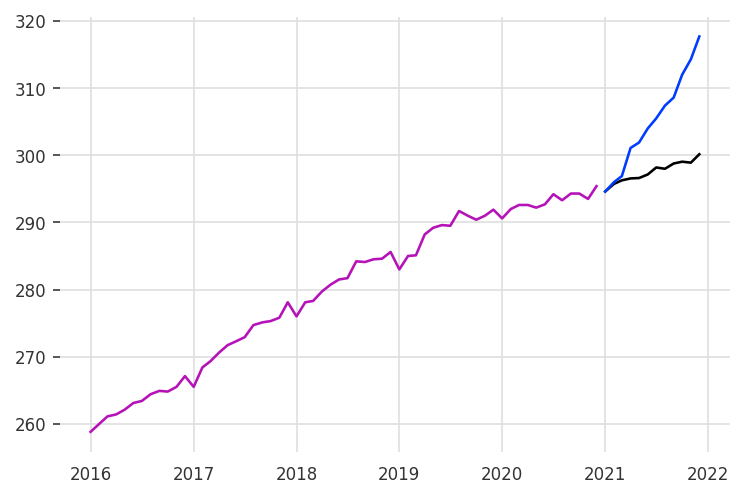

In [36]:
fig1 = plt.plot(df_pred_121_122['Date'],df_pred_121_122['RPI'])
fig2 = plt.plot(dataframes['df_RPI_121_122']['Date'],dataframes['df_RPI_121_122']['RPI'])
fig3 = plt.plot(dataframes['df_RPI_116_121']['Date'],dataframes['df_RPI_116_121']['RPI'])
plt.show()

In [37]:
model = AutoARIMA(start_p=1, max_p=6,
                       start_q=1, max_q=6,
                       start_P=1, max_P=6,
                       start_Q=1, max_Q=6,
                       m=12,
                       trend='t',
                       seasonal=True,
                       trace=True)
model.fit(darts_ts['ts_RPI_115_120'])

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,1,1)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=120.310, Time=0.01 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=103.933, Time=0.23 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=90.807, Time=0.36 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(0,2,1)(1,1,1)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(0,2,1)(0,1,2)[12]             : AIC=inf, Time=0.81 sec
 ARIMA(0,2,1)(1,1,0)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(0,2,1)(1,1,2)[12]             : AIC=97.346, Time=1.12 sec
 ARIMA(0,2,0)(0,1,1)[12]             : AIC=121.683, Time=0.21 sec
 ARIMA(1,2,1)(0,1,1)[12]             : AIC=94.265, Time=0.39 sec
 ARIMA(0,2,2)(0,1,1)[12]             : AIC=95.952, Time=0.33 sec
 ARIMA(1,2,0)(0,1,1)[12]             : AIC=103.837, Time=0.15 sec
 ARIMA(1,2,2)(0,1,1)[12]             : AIC=93.827, Time=0.53 sec
 ARIMA(0,2,1)(0,1,1)[12] intercept   : AIC=90.807, Time=0.

In [47]:
model_ARIMA = ARIMA(p=0,
                    d=2,
                    q=1,
                    seasonal_order=(0,1,1,12),
                    trend='t',
                    random_state=0)

In [48]:
model_ARIMA.fit(darts_ts['ts_RPI_115_120'])

ValueError: In models with integration (`d > 0`) or seasonal integration (`D > 0`), trend terms of lower order than `d + D` cannot be (as they would be eliminated due to the differencing operation). For example, a constant cannot be included in an ARIMA(1, 1, 1) model, but including a linear trend, which would have the same effect as fitting a constant to the differenced data, is allowed.

In [49]:
pred_120_121 = model_ARIMA.predict(12)

AttributeError: 'NoneType' object has no attribute 'forecast'

In [50]:
df_pred_120_121 = pred_120_121.pd_dataframe()

NameError: name 'pred_120_121' is not defined

In [51]:
df_pred_120_121['Date'] = df_pred_120_121.index

NameError: name 'df_pred_120_121' is not defined

In [52]:
fig1 = plt.plot(df_pred_120_121['Date'],df_pred_120_121['RPI'])
fig2 = plt.plot(dataframes['df_RPI_120_121']['Date'],dataframes['df_RPI_120_121']['RPI'])
fig3 = plt.plot(dataframes['df_RPI_115_120']['Date'],dataframes['df_RPI_115_120']['RPI'])
plt.show()

NameError: name 'df_pred_120_121' is not defined

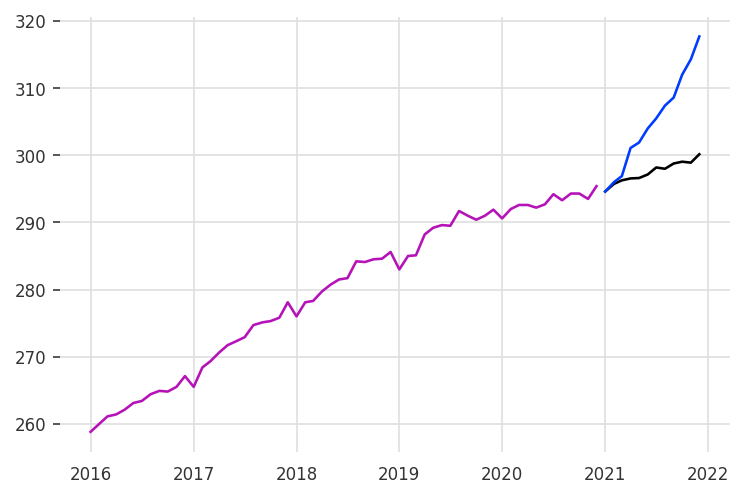

In [53]:
fig1 = plt.plot(df_pred_121_122['Date'],df_pred_121_122['RPI'])
fig2 = plt.plot(dataframes['df_RPI_121_122']['Date'],dataframes['df_RPI_121_122']['RPI'])
fig3 = plt.plot(dataframes['df_RPI_116_121']['Date'],dataframes['df_RPI_116_121']['RPI'])
plt.show()

### Grid Search ARIMA now

In [56]:
parameters = {
    "theta": [0.5, 1, 1.5, 2, 2.5, 3],
    "season_mode": [SeasonalityMode.MULTIPLICATIVE, SeasonalityMode.ADDITIVE]
}

best_model = Theta.gridsearch(parameters=parameters,
                              training_series=training,
                              forecast_horizon=12,
                              start=0.5,
                              last_points_only=False,
                              metric=mape,
                              reduction=np.mean)

best_model.fit(training)
best_model_forecast = best_model.predict(len(validation))

NameError: name 'SeasonalityMode' is not defined

In [ ]:
# ts_RPI_116_121
# Best model:  ARIMA(0,2,1)(0,1,1)[12] 

In [ ]:
darts_ts['ts_RPI_115_120']

<TimeSeries (DataArray) (Date: 60, component: 1, sample: 1)>
array([[[255.4]],

       [[256.7]],

       [[257.1]],

       [[258. ]],

       [[258.5]],

       [[258.9]],

       [[258.6]],

       [[259.8]],

       [[259.6]],

       [[259.5]],

...

       [[285.1]],

       [[288.2]],

       [[289.2]],

       [[289.6]],

       [[289.5]],

       [[291.7]],

       [[291. ]],

       [[290.4]],

       [[291. ]],

       [[291.9]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2015-01-01 2015-02-01 ... 2019-12-01
  * component  (component) object 'RPI'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
# define mape


dataframes['df_RPI_120_121']



,RPI,Date
396,290.6,2020-01-01
397,292.0,2020-02-01
398,292.6,2020-03-01
399,292.6,2020-04-01
400,292.2,2020-05-01
401,292.7,2020-06-01
402,294.2,2020-07-01
403,293.3,2020-08-01
404,294.3,2020-09-01
405,294.3,2020-10-01


In [ ]:
df_pred_120_121

component,RPI,Date
Date,,
2020-01-01,289.821047,2020-01-01
2020-02-01,291.588344,2020-02-01
2020-03-01,291.754781,2020-03-01
2020-04-01,294.453638,2020-04-01
2020-05-01,295.374468,2020-05-01
2020-06-01,295.785480,2020-06-01
2020-07-01,295.772962,2020-07-01
2020-08-01,297.708354,2020-08-01
2020-09-01,297.187272,2020-09-01


In [ ]:
df_pred_120_121['RPI'][0]

289.8210469169918

In [ ]:
i = 0
df_pred_120_121['RPI'][i]

289.8210469169918

In [ ]:
dataframes['df_RPI_120_121'].iloc[1,0]

292.0

In [ ]:
type(aaa)

pandas.core.series.Series

In [ ]:
mape = 0
for i in range(12):
    mape = mape + abs((df_pred_120_121['RPI'][i]/dataframes['df_RPI_120_121'].iloc[i,0]) - 1)
mape = mape/12
mape

0.007970570666226834

In [ ]:
from darts.metrics import mape

In [ ]:
model_ARIMA = ARIMA()

parameters = {
    'p': [0, 1, 2],
    'd': [0, 1, 2],
    'q': [0, 1, 2]
}    

model_ARIMA = ARIMA.gridsearch(parameters=parameters, series=darts_ts['ts_RPI_115_120'],
                               forecast_horizon=12,
#                                start=0.5,
                               metric=mape,
#                                seasonal_order: (0,1,1,12),
                              )
    
model_ARIMA.fit()

2022-09-06 16:53:35 main_logger ERROR: ValueError: Train series only contains 29 elements but ARIMA(0, 0, 0) model requires at least 30 entries


ValueError: Train series only contains 29 elements but ARIMA(0, 0, 0) model requires at least 30 entries

In [ ]:
len(darts_ts['ts_RPI_115_120'])

60

In [ ]:
len(ts_RPI_88_93)

60